In [1]:
import torch
import pickle
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from collections import defaultdict
import random
from final_ship import *

In [2]:
with open("data.pkl", "rb") as f:
    data = pickle.load(f)

with open("labels.pkl", "rb") as f:
    
    labels = pickle.load(f)

print("loaded data")

loaded data


In [3]:
print(len(data), len(labels))

81450 81450


In [4]:
bucket_size = 25
min_samples = 1                  # discard buckets with <10 samples
overrepresented_range = (275, 350)
overrepresented_range2 = (350, 550)
cap_samples = 700               # max samples for 300–425 buckets

# --- Step 1: Bucket data by move count ---
bucketed_data = defaultdict(list)
for i in range(len(data)):
    move_count = labels[i]  # original unnormalized
    bucket_key = int(move_count // bucket_size) * bucket_size
    bucketed_data[bucket_key].append((data[i], move_count))

# --- Step 2: Downsample 300–425 and split train/test ---
x_train, y_train = [], []
x_test, y_test = [], []

for bucket in sorted(bucketed_data):
    samples = bucketed_data[bucket]
    if len(samples) < min_samples:
        continue

    if bucket == 225:
        samples = samples[:min(len(samples), 600)]  
    if bucket == 250:
        samples = samples[:min(len(samples), 800)]  
    if overrepresented_range[0] <= bucket <= overrepresented_range[1]:
        samples = samples[:min(len(samples), cap_samples)]  # cap overrepresented buckets
    if overrepresented_range2[0] <= bucket <= overrepresented_range2[1]:
        samples = samples[:min(len(samples), 500)]
    random.shuffle(samples)
    split = int(0.8 * len(samples))

    x_train += [s[0] for s in samples[:split]]
    y_train += [s[1] for s in samples[:split]]
    x_test  += [s[0] for s in samples[split:]]
    y_test  += [s[1] for s in samples[split:]]

print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(x_test))


8117
8117
2039
2039


/var/folders/1f/vmz43dnn7sd609gnr33rxxhr0000gn/T/ipykernel_17005/1059429871.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


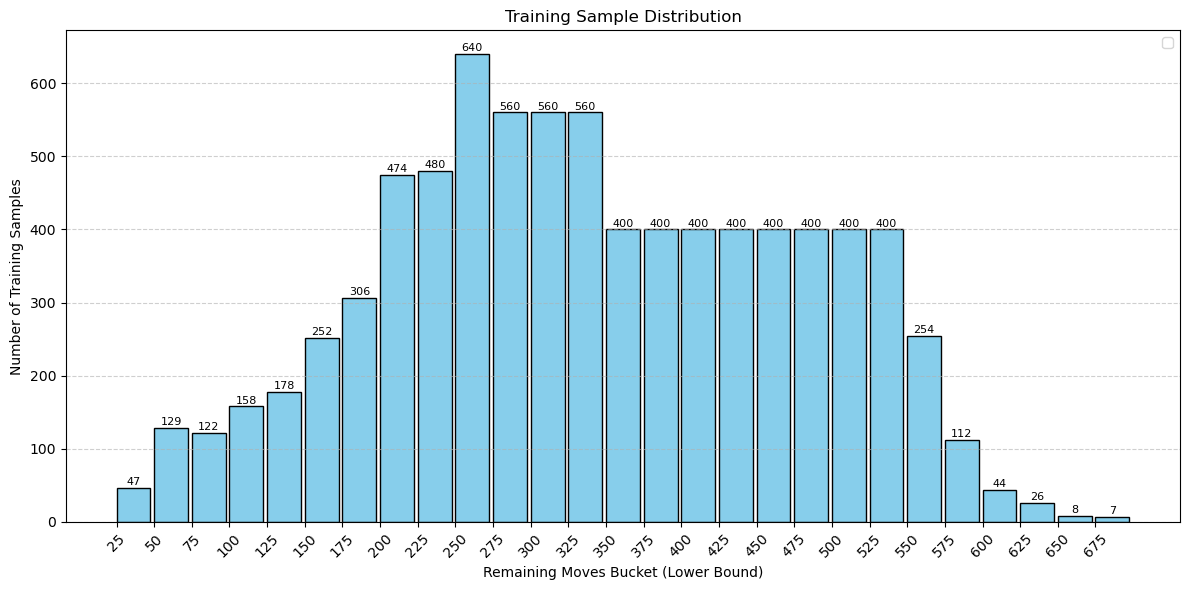

In [5]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Re-bucket the final training data
train_bucket_counts = defaultdict(int)
for label in y_train:
    bucket = int(label // bucket_size) * bucket_size
    train_bucket_counts[bucket] += 1

# Sort and plot
buckets = sorted(train_bucket_counts.keys())
counts = [train_bucket_counts[b] for b in buckets]

plt.figure(figsize=(12, 6))
bars = plt.bar(buckets, counts, width=bucket_size * 0.9, align='edge', color='skyblue', edgecolor='black')

# Add value labels
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, str(count),
             ha='center', va='bottom', fontsize=8)
    
plt.xlabel("Remaining Moves Bucket (Lower Bound)")
plt.ylabel("Number of Training Samples")
plt.title("Training Sample Distribution")
plt.xticks(buckets, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
X_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
Y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)
Y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

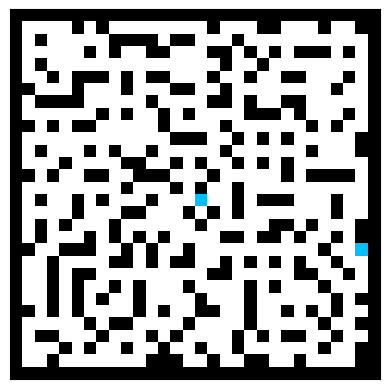

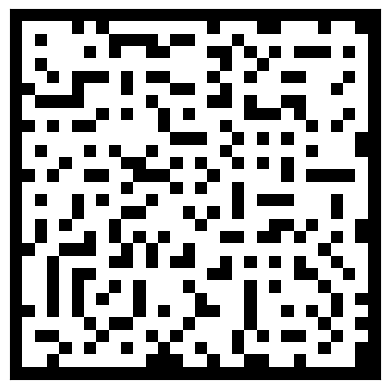

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [41]:
import copy
from visualize import *
len(train_dataset)
empty_ship = copy.deepcopy(data[0])
visualize_ship(empty_ship, None, "", True, True)
for r in range(len(empty_ship)):
    for c in range(len(empty_ship)):
        if empty_ship[r][c] != 0 and empty_ship[r][c] != 1:
            empty_ship[r][c] = 0
visualize_ship(empty_ship, None, "", True, True)

In [89]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 15 * 15, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))      
        x = self.pool(F.relu(self.conv2(x))) 
        x = F.relu(self.conv3(x))       
        x = x.view(x.size(0), -1)       
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [90]:
model = CNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 8

In [86]:
len(train_loader)

127

In [91]:
def my_loss(output, target):
    loss = torch.mean((output - target)**2)
    return loss

In [92]:
from final_ship import *
def get_new_map(curr_map, move):
    old_L = set()
    for i in range(len(curr_map)):
        for j in range(len(curr_map)):
            if curr_map[i][j] == -1:
                old_L.add((i,j))
    new_L = update_location_set(old_L, empty_ship, move)
    new_map = copy.deepcopy(empty_ship)
    for (r,c) in new_L:
        new_map[r][c] = -1
    return new_map

In [93]:
from tqdm import tqdm
import matplotlib.pyplot as plt

train_losses = []
test_losses = []

model.train()
for epoch in range(num_epochs):
    total_train_loss = 0.0
    total_train_samples = 0

    # --- Training loop ---
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        outputs = model(inputs)

        batch_size = inputs.size(0)  # should be 64
        maps_left = []
        maps_right = []
        maps_up = []
        maps_down = []

        for i in range(batch_size):
            curr_map = inputs[i, 0].numpy()  # shape: 30x30

            map_left = get_new_map(curr_map, (0, -1))
            map_right = get_new_map(curr_map, (0, 1))
            map_up = get_new_map(curr_map, (-1, 0))
            map_down = get_new_map(curr_map, (1, 0))

            maps_left.append(torch.tensor(map_left, dtype=torch.float32))
            maps_right.append(torch.tensor(map_right, dtype=torch.float32))
            maps_up.append(torch.tensor(map_up, dtype=torch.float32))
            maps_down.append(torch.tensor(map_down, dtype=torch.float32))

        # Stack and reshape to [64, 1, 30, 30]
        maps_left = torch.stack(maps_left).unsqueeze(1)
        maps_right = torch.stack(maps_right).unsqueeze(1)
        maps_up = torch.stack(maps_up).unsqueeze(1)
        maps_down = torch.stack(maps_down).unsqueeze(1)

        with torch.no_grad():
            C_left = model(maps_left)
            C_right = model(maps_right)
            C_up = model(maps_up)
            C_down = model(maps_down)
            # print(C_left[0][0], C_right[0][0], C_up[0][0], C_down[0][0])

        C_best = torch.min(torch.stack([C_left, C_right, C_up, C_down]), dim=0).values
        # print("C_best", C_best)

        loss = my_loss(outputs, C_best + 1)
        
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * inputs.size(0)
        total_train_samples += inputs.size(0)
    

    avg_train_loss = total_train_loss / total_train_samples
    train_losses.append(avg_train_loss)

    # --- Evaluation on test set ---
    model.eval()
    total_test_loss = 0.0
    total_test_samples = 0
    with torch.no_grad():
        for inputs, _ in test_loader:
            outputs = model(inputs)
            batch_size = inputs.size(0)

            maps_left = []
            maps_right = []
            maps_up = []
            maps_down = []

            for i in range(batch_size):
                curr_map = inputs[i, 0].numpy()

                map_left = get_new_map(curr_map, (0, -1))
                map_right = get_new_map(curr_map, (0, 1))
                map_up = get_new_map(curr_map, (-1, 0))
                map_down = get_new_map(curr_map, (1, 0))

                maps_left.append(torch.tensor(map_left, dtype=torch.float32))
                maps_right.append(torch.tensor(map_right, dtype=torch.float32))
                maps_up.append(torch.tensor(map_up, dtype=torch.float32))
                maps_down.append(torch.tensor(map_down, dtype=torch.float32))

            maps_left = torch.stack(maps_left).unsqueeze(1)
            maps_right = torch.stack(maps_right).unsqueeze(1)
            maps_up = torch.stack(maps_up).unsqueeze(1)
            maps_down = torch.stack(maps_down).unsqueeze(1)

            C_left = model(maps_left)
            C_right = model(maps_right)
            C_up = model(maps_up)
            C_down = model(maps_down)

            C_best = torch.min(torch.stack([C_left, C_right, C_up, C_down]), dim=0).values

            loss = my_loss(outputs, C_best + 1)
            total_test_loss += loss.item() * inputs.size(0)
            total_test_samples += inputs.size(0)

    avg_test_loss = total_test_loss / total_test_samples
    test_losses.append(avg_test_loss)


    model.train()  # switch back to training mode

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")


Epoch 1: 100%|██████████| 127/127 [01:10<00:00,  1.81it/s]


Epoch 1/8, Train Loss: 2.166003, Test Loss: 0.601220


Epoch 2: 100%|██████████| 127/127 [01:10<00:00,  1.80it/s]


Epoch 2/8, Train Loss: 2.565091, Test Loss: 0.641216


Epoch 3: 100%|██████████| 127/127 [01:10<00:00,  1.80it/s]


Epoch 3/8, Train Loss: 2.082683, Test Loss: 6.189665


Epoch 4: 100%|██████████| 127/127 [01:10<00:00,  1.81it/s]


Epoch 4/8, Train Loss: 4.150843, Test Loss: 0.714306


Epoch 5: 100%|██████████| 127/127 [01:10<00:00,  1.81it/s]


Epoch 5/8, Train Loss: 2.239904, Test Loss: 4.402102


Epoch 6: 100%|██████████| 127/127 [01:10<00:00,  1.80it/s]


Epoch 6/8, Train Loss: 4.464442, Test Loss: 1.234575


Epoch 7: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s]


Epoch 7/8, Train Loss: 5.283362, Test Loss: 5.611218


Epoch 8: 100%|██████████| 127/127 [01:10<00:00,  1.79it/s]


Epoch 8/8, Train Loss: 2.125495, Test Loss: 1.329317


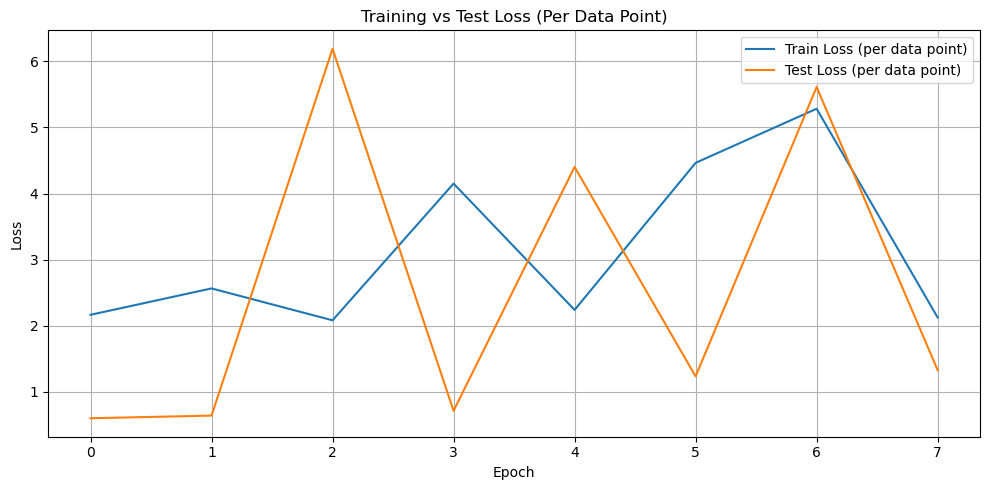

In [94]:
# --- Plotting losses per data point ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss (per data point)')
plt.plot(test_losses, label='Test Loss (per data point)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Test Loss (Per Data Point)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [112]:
def evaluate_bellman_policy(model, ship, open_cells, to_tensor_fn, max_steps=1000, samples_per_size=100):
    from collections import defaultdict

    avg_steps = defaultdict(list)
    sizes = list(range(544,2,-4))

    for size in tqdm(sizes):
        for _ in range(samples_per_size):
            L = set(random.sample(list(open_cells), size))
            print(len(list(L)))
            curr_L = L.copy()
            steps = 0

            while len(curr_L) > 1 and steps < max_steps:
                best_move = None
                best_cost = float('inf')
                best_L = None

                for move in directions:
                    new_L = update_location_set(curr_L, ship, move)
                    input_tensor = to_tensor_fn(new_L, ship)
                    with torch.no_grad():
                        cost = model(input_tensor).item()
                    if cost < best_cost:
                        best_cost = cost
                        best_move = move
                        best_L = new_L

                if best_L is None:
                    break  # stuck

                curr_L = best_L
                steps += 1
            
            print(steps)

            if len(curr_L) == 1:
                avg_steps[size].append(steps)

    # Average results
    averaged = {size: sum(v)/len(v) for size, v in avg_steps.items() if v}
    return averaged


In [113]:
def to_tensor(L, ship):
    """
    Convert a set of possible locations L and the ship map into a tensor input for the model.
    
    L: set of (r, c) tuples — possible bot locations
    ship: 2D list or numpy array with 0=open, 1=wall
    
    Output: PyTorch tensor of shape (1, 1, H, W)
    """

    map_copy = copy.deepcopy(ship)  # don't modify original

    for r in range(len(map_copy)):
        for c in range(len(map_copy[0])):
            if map_copy[r][c] == -1:
                map_copy[r][c] = 0  # clear any previous markings

    for r, c in L:
        map_copy[r][c] = -1  # mark possible bot positions

    tensor = torch.tensor(np.array(map_copy), dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return tensor


In [115]:
open_cells = set()
for r in range(len(empty_ship)):
    for c in range(len(empty_ship)):
        if empty_ship[r][c] == 0:
            open_cells.add((r,c))

results = evaluate_bellman_policy(model, empty_ship, open_cells, to_tensor)

# Plot
plt.figure(figsize=(10,5))
x_vals = sorted(results.keys())
y_vals = [results[k] for k in x_vals]
plt.plot(x_vals, y_vals, marker='o', linestyle='-', color='purple')
plt.xlabel("|L| Initial Size")
plt.ylabel("Average Steps to Localize")
plt.title("Policy Performance Using Bellman-Trained Model")
plt.grid(True)
plt.tight_layout()
plt.show()

  0%|          | 0/136 [00:00<?, ?it/s]

544
1000
544


  0%|          | 0/136 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [33]:
torch.save(model.state_dict(), "model_rl_weights.pth")